In [19]:
import tensorflow as tf
from keras.losses import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred))
model = tf.keras.models.load_model("../model/LSTM_4_4.keras", custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [20]:
from pandas import read_csv
#Load data set
look_back = 2
series_influ_A_df = read_csv('../temp_data/influA_vietnam_last_10_days.csv', index_col=0, engine='python')
train_df = series_influ_A_df.iloc[0:735]
test_df = series_influ_A_df.iloc[735-look_back:]
# series_influ_A_df = series_influ_A_df["Influenza A - All types of surveillance"]

In [21]:
series_influ_A_df = series_influ_A_df[["Influenza A - All types of surveillance", "temp", "tempmax", "dew","windspeed"]]
series_influ_A_df = series_influ_A_df.dropna()

series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test

train = dataset[:735, :]
test = dataset[735-look_back:, :]

import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [22]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [23]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.vstack((X[-1][-1], predicted.reshape(1,5)))
        X = np.append(X, [X_continue], axis=0)
    import json
    # with open('./X.json', 'w') as f:
    #     json.dump(X.tolist(), f)
    return result
    
# make predictions
# testPredict = model.predict(testX)
testPredict = predict(testX[0], len(test)-look_back, model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY_, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 7.05 RMSE


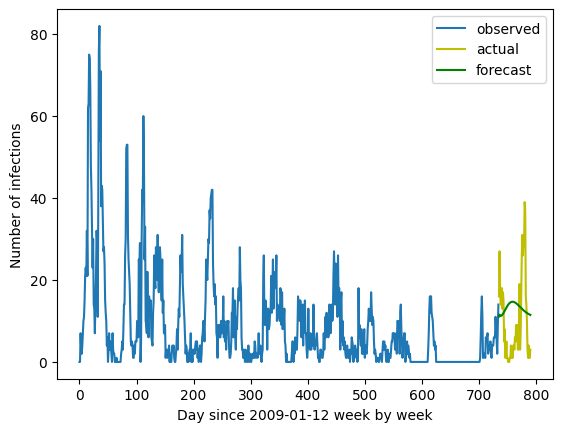

In [24]:

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([dataset.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0].reshape(-1)
testPlot = np.empty([dataset.shape[0]])
testPlot[:] = np.nan
testPlot[len(train):len(dataset)] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual")
plt.plot(testPredictPlot, color = 'green', label="forecast")
plt.xlabel("Day since 2009-01-12 week by week")
plt.ylabel("Number of infections")
plt.legend(["observed", "actual", "forecast"])
plt.show()